In [1]:
import pickle as pkl
import numpy as np
from utils import *
import matplotlib.pyplot as plt


In [2]:
# import data
with open('state.pkl', 'rb') as f:
    state = pkl.load(f)


In [3]:
def add_noise(mean, var):
    return np.random.normal(mean, var)


In [13]:
# define sensor relative position
sensor_pos = np.array([0.5, 0.0, -1])

def sensor_from_cg(t,sensor_pos):
    com = cg(t)
    return com + sensor_pos

sensor_from_cg(0, sensor_pos)


array([1.97144457, 1.47144457, 0.47144457])

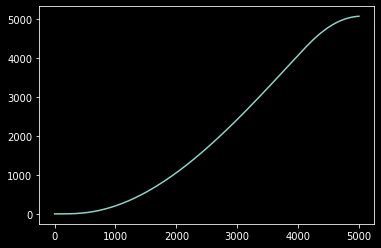

In [5]:
spins = [s[15] for s in state]
orientations = [0]
for i in range(1,len(spins)):
    orientations.append((orientations[-1] + spins[i-1]*0.01))
plt.plot(orientations)


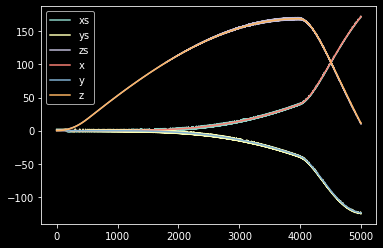

In [6]:

sensor_positions = []
for i in range(len(state)):
    sens_rel = sensor_from_cg(i*0.01, sensor_pos)
    abs_pos = state[i][:3]
    # rotate sens_rel about the quaternion
    ang = orientations[i]
    axis = state[i][3:6]
    q = np.array([np.cos(ang/2),
                  axis[0]*np.sin(ang/2),
                  axis[1]*np.sin(ang/2),
                  axis[2]*np.sin(ang/2)])
    
    sens_abs = rot_by_q(q,sens_rel)
    sensor_positions.append(abs_pos + sens_abs)
    
plt.plot(np.array(sensor_positions)[:,0],label='xs')
plt.plot(np.array(sensor_positions)[:,1],label='ys')
plt.plot(np.array(sensor_positions)[:,2],label='zs')
plt.plot([s[0] for s in state],label='x')
plt.plot([s[1] for s in state],label='y')
plt.plot([s[2] for s in state],label='z')
plt.legend()
# display plot in external window
plt.show(True)


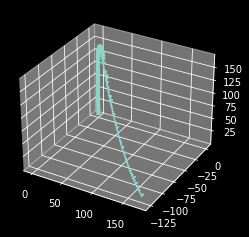

In [7]:
# %matplotlib qt
# plot 3d sensor positions
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot3D(np.array(sensor_positions)[:,0],np.array(sensor_positions)[:,1],np.array(sensor_positions)[:,2])


In [8]:
%matplotlib inline


## Part 2: Generating Sensor Data

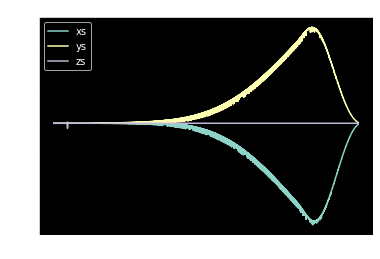

In [9]:
# Initialize sensor data
acc = [np.array(s[6:9]) for s in state]
x = np.array([np.array(s[:3]) for s in state])
w = [np.array(s[13:16]) for s in state]

sens_accel = []
for i in range(len(state)):
    sens_accel.append(acc[i] + np.cross(w[i],(np.cross(w[i],sensor_positions[i]))))

plt.plot(np.array(sens_accel)[:,0],label='xs')
plt.plot(np.array(sens_accel)[:,1],label='ys')
plt.plot(np.array(sens_accel)[:,2],label='zs')
plt.legend()
plt.show()


In [10]:
# add noise to sensor data
accel_var = 529000 # µg
gyro_var = 0.00225 # d/s

# convert to m/s^2
accel_var *= 9.81/1e6
gyro_var *= np.pi/180

sens_accel_noisy = []
for i in range(len(state)):
    sens_accel_noisy.append(sens_accel[i] + np.array([add_noise(0,accel_var),add_noise(0,accel_var),add_noise(0,accel_var)]))

sens_gyro_noisy = []
for i in range(len(state)):
    sens_gyro_noisy.append(w[i] + np.array([add_noise(0,gyro_var),add_noise(0,gyro_var),add_noise(0,gyro_var)]))


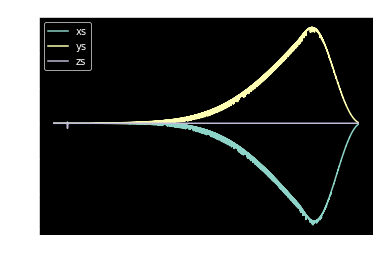

In [11]:
# plot noisy sensor data
plt.plot(np.array(sens_accel_noisy)[:,0],label='xs')
plt.plot(np.array(sens_accel_noisy)[:,1],label='ys')
plt.plot(np.array(sens_accel_noisy)[:,2],label='zs')
plt.legend()
plt.show()


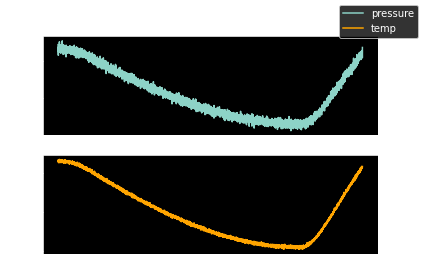

In [15]:
# generate pressure and temperature data
def height_to_pressure(height):
    # Constants for the barometric formula
    g = 9.80665  # Acceleration due to gravity (m/s^2)
    M = 0.0289644  # Molar mass of Earth's air (kg/mol)
    R = 8.31432  # Universal gas constant (J/(mol*K))
    T0 = 288.15  # Standard temperature at sea level (K)
    P0 = 101325  # Standard pressure at sea level (Pa)

    # Calculate the temperature at the given height
    temperature = T0 - 0.0065 * height

    # Calculate the pressure using the barometric formula
    pressure = P0 * np.power((1 - (0.0065 * height) / T0), (g * M) / (R * 0.0065)) / 1e3

    return pressure, temperature

pts = [height_to_pressure(s[2]) for s in state]
ps = [p[0] + add_noise(0,0.06) for p in pts] #hectopascals
ts = [p[1] + add_noise(0,0.01) for p in pts]

fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
ax1.plot(ps,label='pressure')
ax2.plot(ts,label='temp',color='orange')
fig.legend()
plt.show()


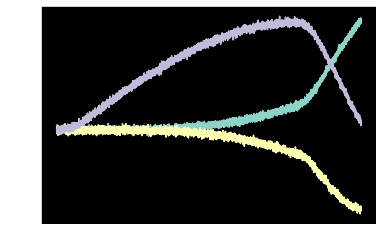

In [ ]:
# generate GPS data (assume cartesian coordinates)
noisy_x  = [add_noise(x,3) for x in x]
plt.plot(np.array(noisy_x)[:,0],label='xs')
plt.plot(np.array(noisy_x)[:,1],label='ys')
plt.plot(np.array(noisy_x)[:,2],label='zs')


In [ ]:
sensor_data ={
    'accel': sens_accel_noisy,
    'gyro': sens_gyro_noisy,
    'pressure': ps,
    'temp': ts,
    'gps': noisy_x,
    'sensor_pos': sensor_positions,
    'rocket_pos': np.array([s[:3] for s in state])
}

with open('sensor_data_with_truth.pkl', 'wb') as f:
    pkl.dump(sensor_data, f)
